# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "2_end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [3]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()
#상위 5개 표시 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()
#housing 데이터의 ocean_proximity 컬럼의 value 값 카운팅 
#value_counts(dropna = TRUE, ascending = False, sort = TRUE,normalize = False, bins= x or bins[x1, x2, x3...])
#dropna : NAN 값 반환 , ascending : 오름차순 정렬 여부, sort 정렬 여부, normalize : 값의 상대 빈도 , bins : 연속자료를 이산자료로 binning 
#value_counts().sort_index(ascending = TRUE) : index값 정렬
#groupby("column값 c1")["column값 c2"].value_counts() : c1에 대한 c2의 값 확인
# value_counts() 메서드는 pandas series 객체를 반환
# 데이터프레임으로 변환하는 경우 코드 끝에 .to_frame() 추가
# 열에서 원하는 값 반환 value_counts().loc[lambda x : 조건식 ex: x > 4]  


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


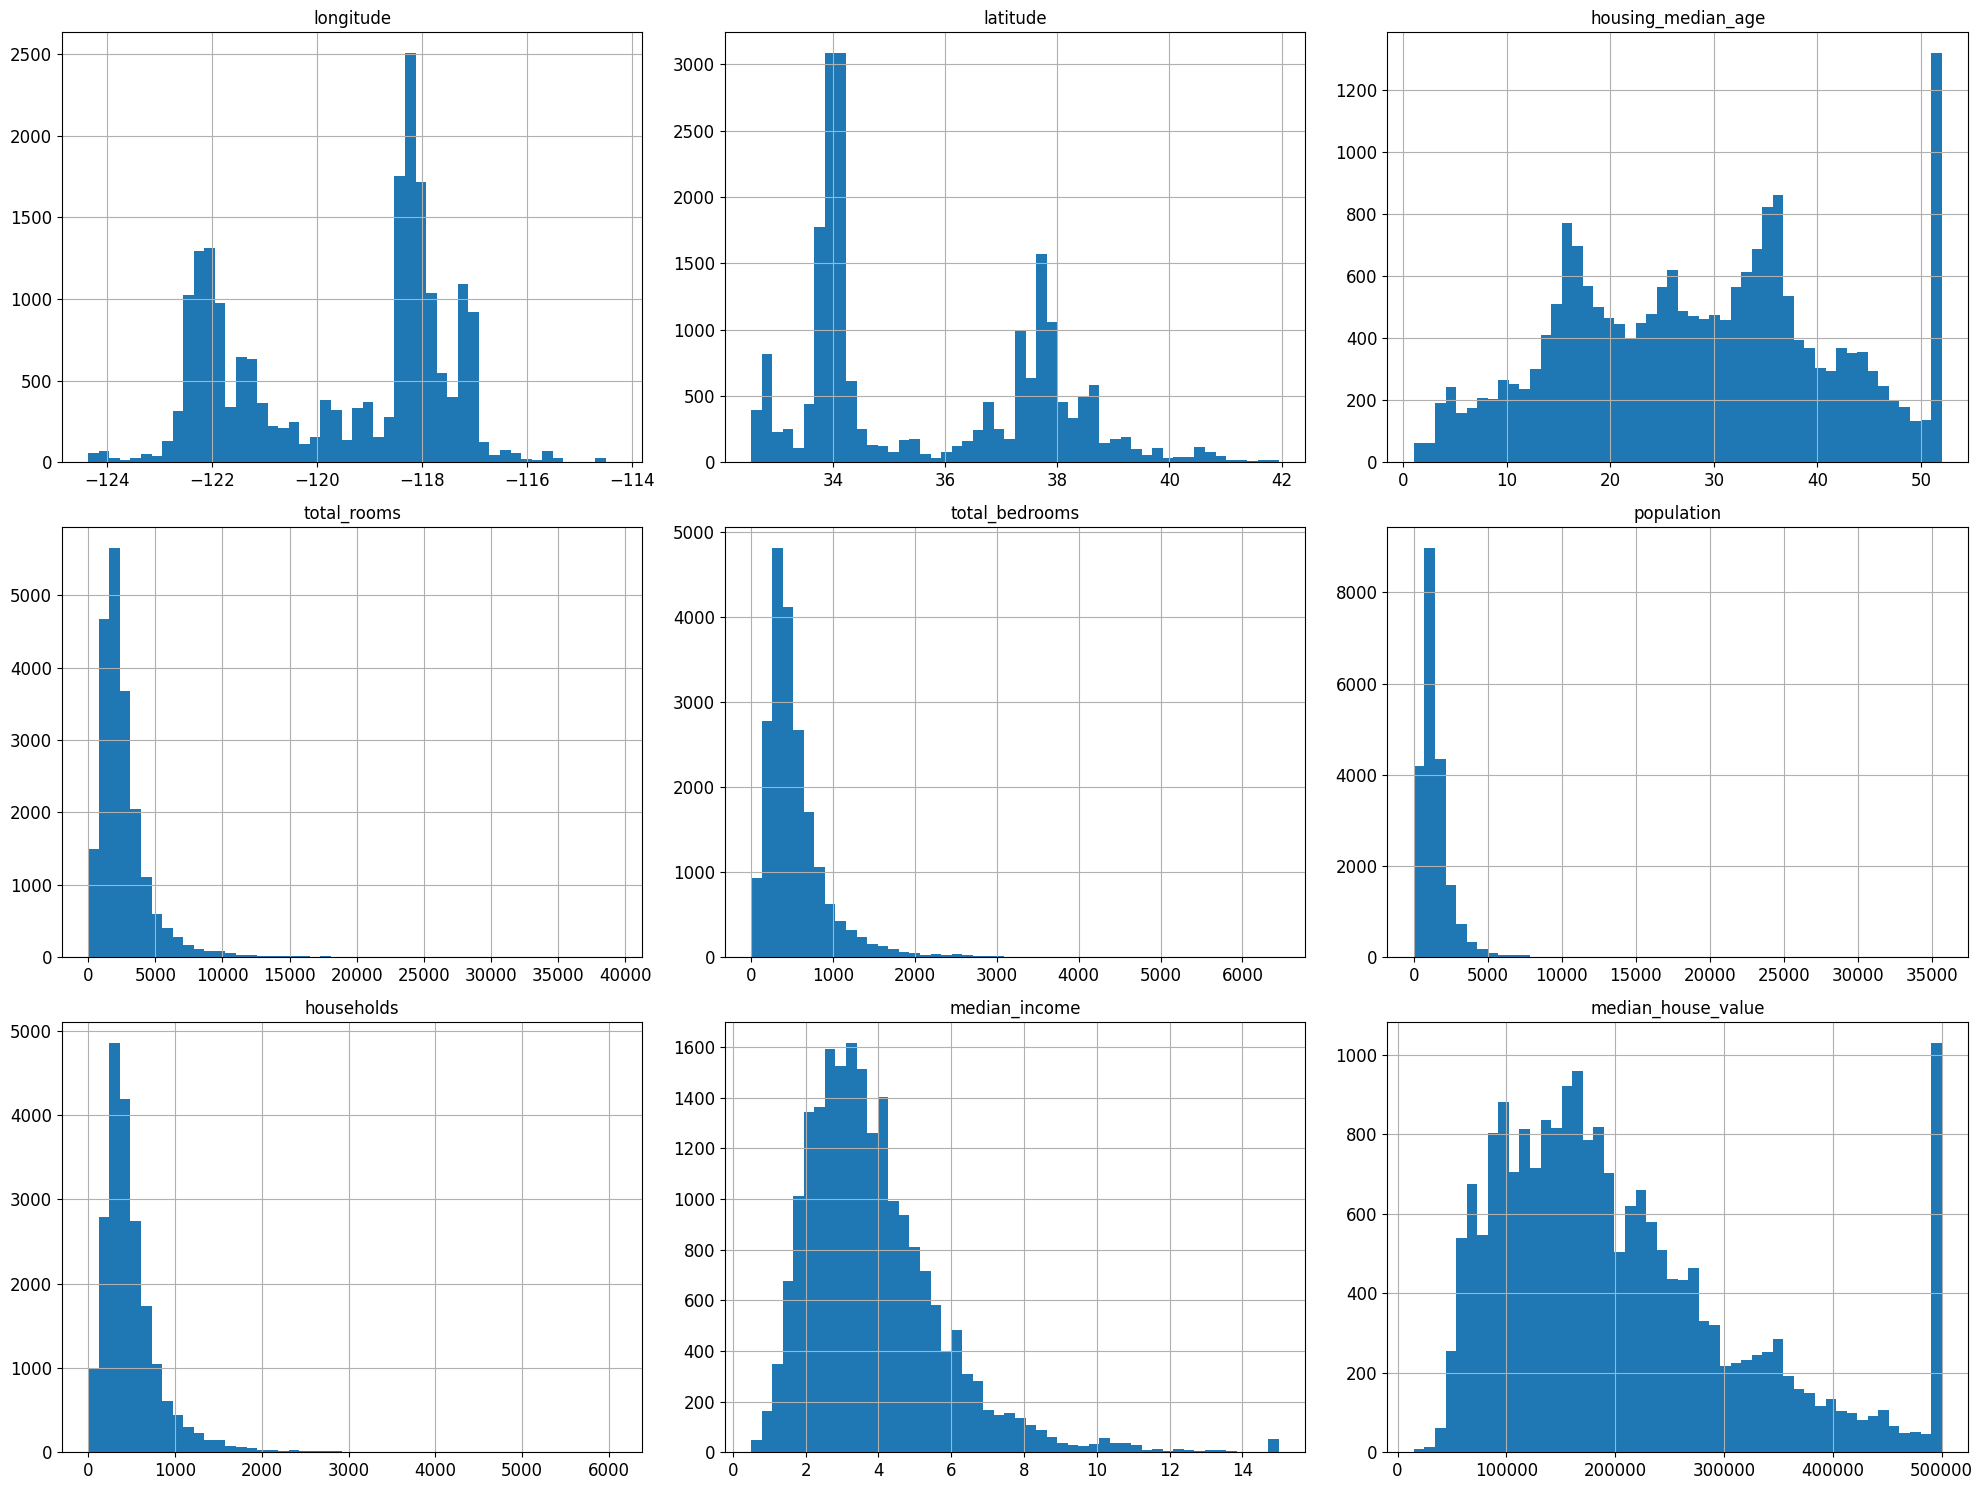

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [11]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [12]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [14]:
len(test_set)

4128

In [15]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [16]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [17]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [18]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [19]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [20]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [21]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [22]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot: >

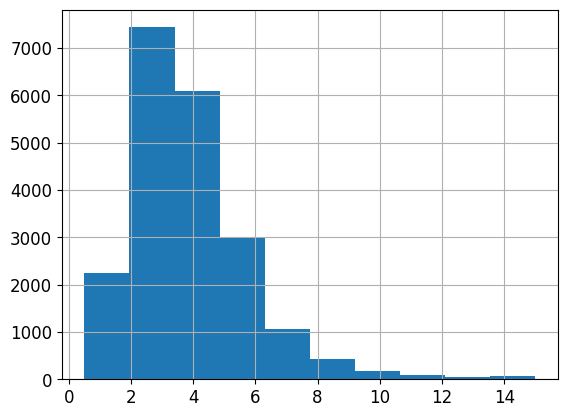

In [23]:
housing["median_income"].hist()

In [24]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
#pd.cut(데이터, 구간의 개수, 레이블명)
#housing["income_cat", "median_income"].head()

In [25]:
housing[["income_cat","median_income"]].head()

,income_cat,median_income
0,5,8.3252
1,5,8.3014
2,5,7.2574
3,4,5.6431
4,3,3.8462


In [26]:
housing["income_cat"].value_counts().sort_index()

1     822
2    6581
3    7236
4    3639
5    2362
Name: income_cat, dtype: int64

<AxesSubplot: >

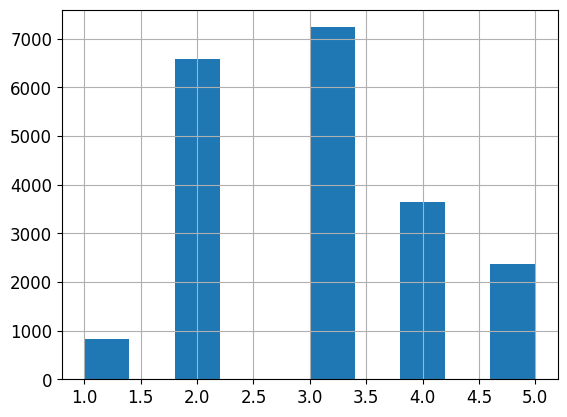

In [27]:
housing["income_cat"].hist()

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
print(len(housing))
print(len(strat_test_set))

20640
4128


In [30]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [31]:
housing["income_cat"].value_counts() #/ len(housing)

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [32]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data) # "income_cat" 비율 

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing), # 모든 housin 데이터 에 대한 비율
    "Stratified": income_cat_proportions(strat_test_set), # strat_test_set 에 대한 비율
    "Random": income_cat_proportions(test_set), # 랜덤 test_set 에 대한 비율 
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] -100
#Rand. %error 컬럼 생성 
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
#Strat. &error 컬럼 생성 

In [33]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [34]:
#미반영 시킬 column 데이터 삭제 
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    #axis= 0 : 행 , axis =1 : 열 , 행 또는 열 이름 지정해서 삭제 가능 
    # inplace : True는 카피본을 만들지 않고(returns none) 원본에 변경을 가함, False는 카피본에 변경을 가함(returns a copy)


# Discover and visualize the data to gain insights

In [35]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


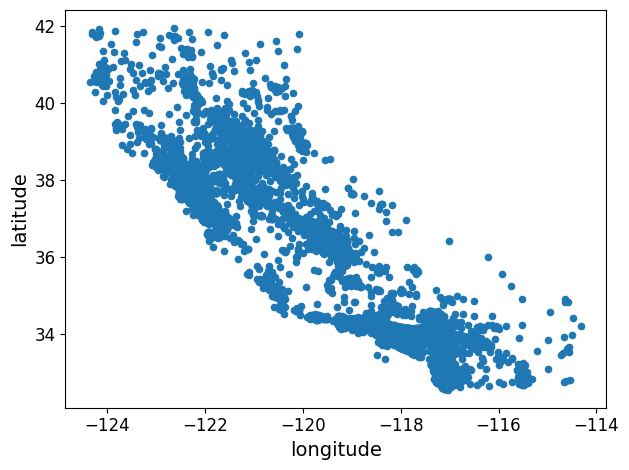

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


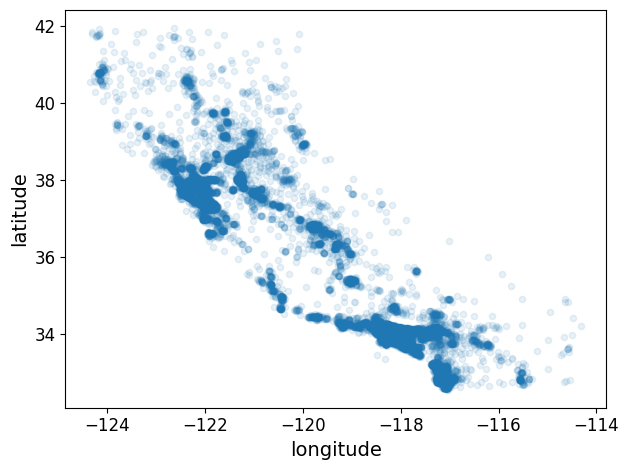

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)#alpha를 적용함으로써 밀집률을 나타냄
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


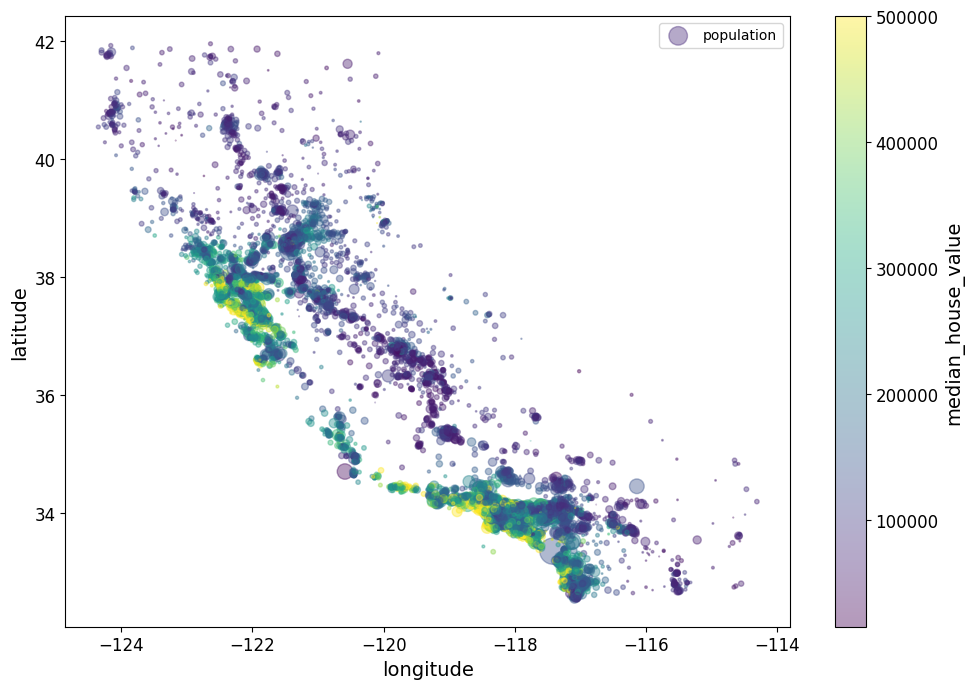

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("seismic"), colorbar=True,
    sharex=False)
    # s : 사이즈(오른쪽 상단 위) , c : 색깔(숫자에 따른 변화) , cmap 컬러바 종류
plt.legend()
save_fig("housing_prices_scatterplot")

In [39]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x1ba9b53f310>)

C:\Users\bk\AppData\Local\Temp\ipykernel_3384\1148410459.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


Saving figure california_housing_prices_plot


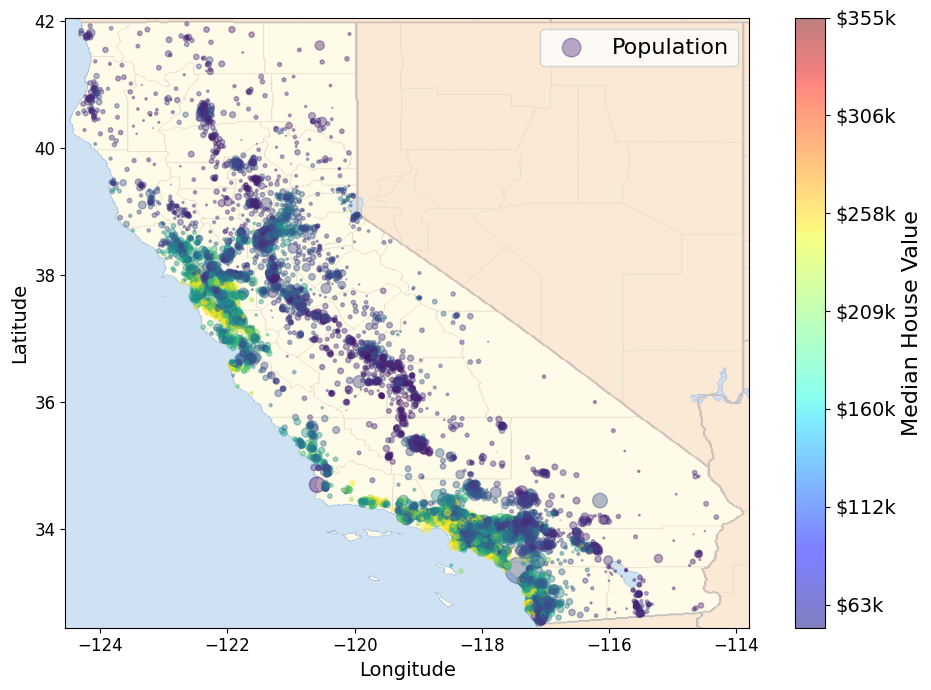

In [40]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet")) # extent 로 산포도와 크기를 맞춤 
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [41]:
#상관도 구하기
corr_matrix = housing.corr()
corr_matrix 

C:\Users\bk\AppData\Local\Temp\ipykernel_3384\1671617925.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [42]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


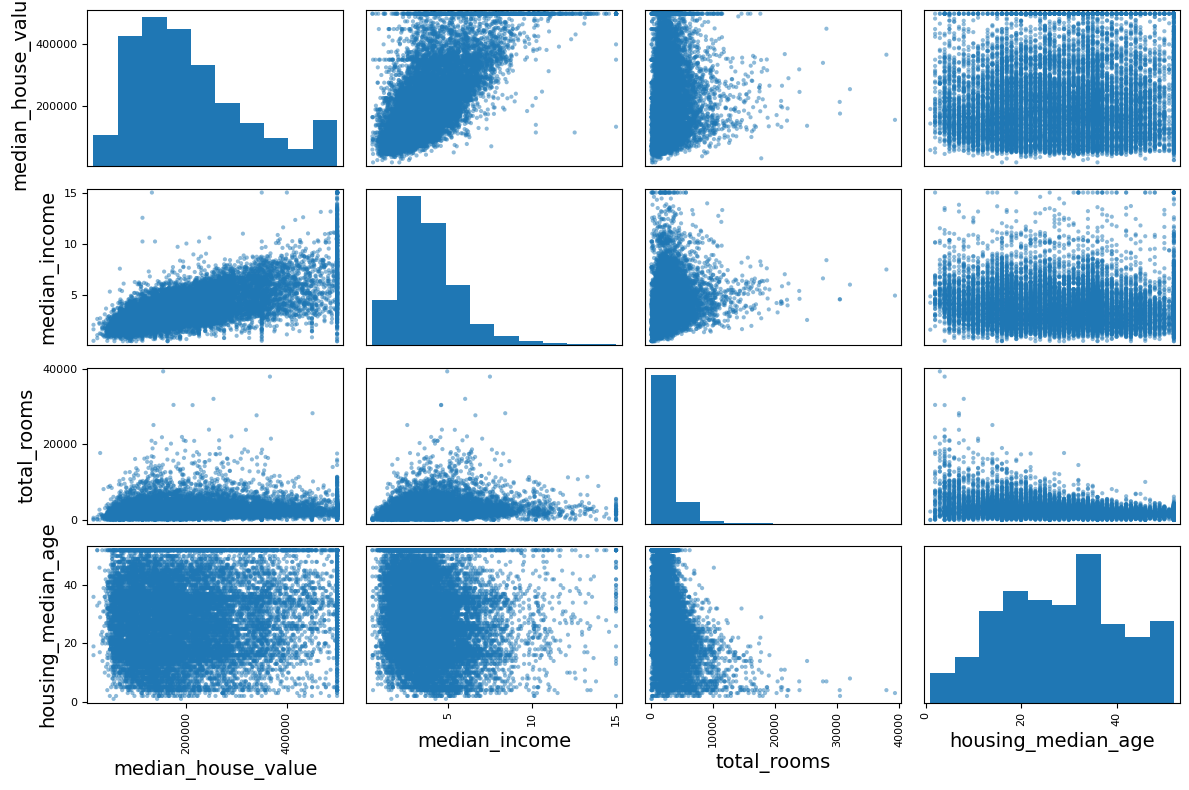

In [43]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"] #corr_matrix 상위 4개 
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


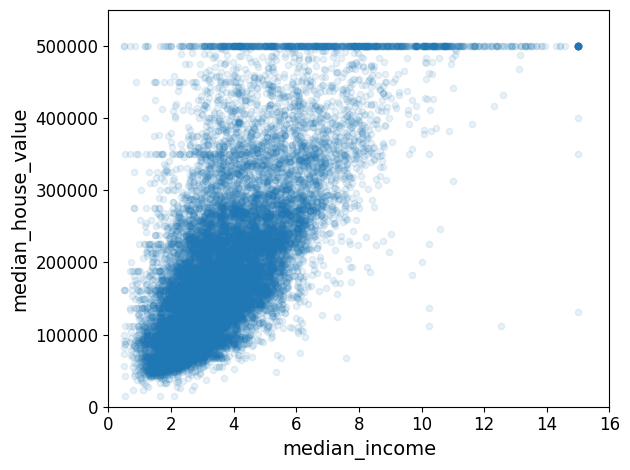

In [44]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [45]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [46]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

C:\Users\bk\AppData\Local\Temp\ipykernel_3384\826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

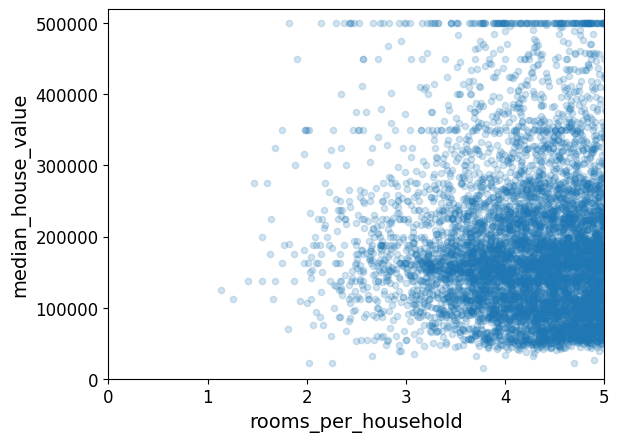

In [47]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [48]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [49]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
# drop() creates a copy of the data and does not affect strat_train_set
housing_labels = strat_train_set["median_house_value"].copy()
housing_labels.head().to_frame()

,median_house_value
12655,72100.0
15502,279600.0
2908,82700.0
14053,112500.0
20496,238300.0


In [50]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [51]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head() #행 기준으로 null값 찾기 
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [52]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1: Get rid of the corresponding districts # 결측치 제거 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [53]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2: Get rid of the whole attribute

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [54]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
# option 3: Set the values to some value (zero, the mean, the median, etc.)

In [55]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [56]:
from sklearn.impute import SimpleImputer # handy class to take care of missing values
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [57]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [58]:
imputer.fit(housing_num)
# computed the median of each attribute and stored the result in its statistics_ instance variable

SimpleImputer(strategy='median')

In [59]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Check that this is the same as manually computing the median of each attribute:

In [60]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:

In [61]:
X = imputer.transform(housing_num)
# plain NumPy array containing the transformed features

In [62]:
imputer.strategy

'median'

In [63]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
# to put it back into a pandas DataFrame

In [64]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [65]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [66]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [67]:
# convert categories from text to numbers
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder() # 문자형을 숫자형으로 바꿔줌
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [68]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

ML algorithms will assume that two nearby values are more similar than two distant values. 
This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”). 

But it is obviously not the case for the ocean_proximity column. a common solution is one-hot encoding: to create one binary attribute per category: 

one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on

In [69]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [70]:
housing_cat_1hot.toarray() # to convert SciPy sparse matrix to a (dense) NumPy array

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [71]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [72]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Let's create a custom transformer to add extra attributes:

Create a class and implement three methods: fit() (returning self), transform(), and fit_transform() (get it free by simply adding TransformerMixin as a base class)

add BaseEstimator as a base class (and avoid *args and **kargs in your constructor),
and get two extra methods (get_params() and set_params())

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [74]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### Feature Scaling
With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. 

Ex. total number of rooms: 6 - 39,320. median incomes: 0 - 15. 

Note that scaling the target values is generally not required.

#### Min-max scaling (normalization) 
(X-min)/(max-min) : range of 0-1 -> Scikit-Learn transformer: MinMaxScaler (feature_range hyperparameter changes the range other than 0–1.

#### Standardization 
(X-mean)/sd : zero mean and unit variance. Does not bound values, but much less affected by outliers. -> Scikit-Learn transformer : StandardScaler

Now let's build a pipeline for preprocessing the numerical attributes:

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),  # data fixing. Must be tranformer.
        ('attribs_adder', CombinedAttributesAdder()),   # custom transformer. Must be tranformer
        ('std_scaler', StandardScaler()),               # feature scaling
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [76]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [77]:
from sklearn.compose import ColumnTransformer
# ColumnTransformer: handles all columns, applying the appropriate transformations 
# to each column
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

OneHotEncoder returns a sparse matrix, while the num_pipeline returns a dense matrix. =>  ColumnTransformer estimates the density of the final matrix (i.e., the ratio of nonzero cells) => returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3). 

In this example, it returns a dense matrix.

In [78]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [79]:
housing_prepared.shape

(16512, 16)

#### Dataset is ready now!

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [81]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [82]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [83]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [84]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Select and train a model 

In [85]:
# First model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [86]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


Compare against the actual values:

In [87]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


It works. But the first prediction is off by close to 40%!

In [88]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

In [89]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

Most districts’ median_housing_values range between USD120,000 - USD265,000, <br> so a typical prediction error of $68,628 is not very satisfying

An example of a model **underfitting** the training data  
=> the features do not provide enough information to make good predictions,  
or the model is not powerful enough

In [90]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915801

In [91]:
# Using a more powerful model
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [92]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Model has badly **overfit** the data

# Fine-tune your model

#### K-fold cross-validation: 
randomly splits the training set into K distinct subsets called *folds*,  
=> it trains and evaluates the Decision Tree model K times,  
picking a different fold for evaluation every time and training on the other K-1 folds.  
The result is an array containing the k evaluation scores:

In [93]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn’s cross-validation features expect a *utility function* (greater is better) rather than a *cost function* (lower is better),  <br>so the scoring function is actually the opposite of the MSE (i.e., a negative value), and  
computes **-scores** before calculating the square root.

In [94]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


Decision Tree performs worse than the Linear Regression model => Overfitting. <br>
Cross-validation also allows a measure of how precise this estimate is 
(i.e., its standard deviation).

In [95]:
#Cross validation for linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180653


In [96]:
#scores = cross_val_score(lin_reg, housing_prepared, housing_labels,                          scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     71629.890097
std       3071.663088
min      68960.045444
25%      69602.930320
50%      70525.140962
75%      72753.038693
max      79094.741237
dtype: float64

**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [97]:
# Another model (chap. 7)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [98]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [99]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


Score on the training set(*18603*) is still much lower than on the validation sets(*50182*),  
=> the model is still overfitting the training set

In [100]:
# Another model (chap. 5)
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

### Grid Search<br>
Find a great combination of hyperparameter values.

In [101]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [102]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [103]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [104]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [105]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.055040,0.001579,0.002393,4.890450e-04,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.187200,0.010015,0.007380,4.886166e-04,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.542205,0.002640,0.020944,1.784161e-07,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.083984,0.001028,0.002992,1.168008e-07,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.274984,0.001609,0.007580,4.885193e-04,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.817325,0.005588,0.020545,4.886166e-04,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.105118,0.001739,0.002793,7.463019e-04,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.356471,0.003102,0.007384,4.924993e-04,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.075913,0.006948,0.021143,3.987314e-04,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.135058,0.002529,0.002794,3.994975e-04,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


In [106]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BA9B61C370>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BA9B615730>},
                   random_state=42, scoring='neg_mean_squared_error')

In [107]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


### Analyze the Best Models and Their Errors
The relative importance of each attribute for making accurate predictions:

In [108]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [109]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887772, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

Try dropping some of the less useful features<br>
e.g., apparently only 'INLAND' is really useful, so try dropping the others.

Look at the specific errors that the system makes  
=> try to understand why and what could fix the problem  
(adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

### Evaluate Your System on the Test Set
Get the predictors and the labels from test set, run full_pipeline to transform the data

In [110]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [111]:
final_rmse

47873.26095812988

How precise this estimate is?<br>
We can compute a 95% confidence interval for the test RMSE:

In [112]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

RMSE will be between above values with 95% confidence.<br>
We could compute the interval manually like this:

In [113]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45893.360828285535, 49774.46796717361)

Alternatively, we could use a z-scores rather than t-scores:

In [114]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45893.9540110131, 49773.921030650374)

# Extra material

## A full pipeline with both preparation and prediction

In [115]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])